In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%load_ext autoreload
%autoreload 2
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm

import sys

sys.path.append('../')

In [35]:
from clean_helpers import *

take_full = True
test_locally = False
create_new_text_files = True

# Specify here what cleaning functions you want to use
cleaning_options = ['clean_new_line', 'remove_stopwords', 'clean_tags',
                    'clean_punctuation', 'remove_numbers', 'lemmatize']


clean = {
    "clean_new_line": clean_new_line,
    "lowercase": lowercase,
    "lemmatize": lemmatize,
    "remove_stopwords": remove_stopwords,
    "translate": perform_translation,
    "clean_punctuation": clean_punctuation,
    "clean_tags" : clean_tags,
    "remove_numbers": remove_numbers,
}


# algorithm_used = ""
# algorithm = {
#     "naive_bayes": ,
#     "logistic_regression": ,
#     "svm": ,
#     "lstm":,
#     "fasttext":,
#     "cnn": ,
# }

# options = []
# additional_options = {
#     "count_frequency": ,
#     "count_ngrams": ,
    
# }


In [3]:
input_file_pos = 'Data/train_pos.txt'
if take_full:
    input_file_pos = 'Data/train_pos_full.txt'
  
input_file_neg = 'Data/train_neg.txt'
if take_full:
    input_file_neg = 'Data/train_neg_full.txt'
    
list_of_pos_sentences = []
with open(input_file_pos, 'r') as f:
    for line in f:
        list_of_pos_sentences.append(line)
 
list_of_neg_sentences = []
with open(input_file_neg, 'r') as f:
    for line in f:
        list_of_neg_sentences.append(line)

In [4]:
from data_handling import build_sentences

df = build_sentences(list_of_pos_sentences, list_of_neg_sentences)

In [ ]:
df[df.sentence.apply(lambda x: len(x.split("\n"))) > 2].head()

In [5]:
# Perform all the cleaning options selected

for clean_option in cleaning_options:
    counter_of_occurrences = 0
    %time df = clean[clean_option](df)
    print(clean_option)
    print(df.head())
    print(df.iloc[1].sentence)
    print("################################\n\n")
    

df.head()

CPU times: user 3.35 s, sys: 79.5 ms, total: 3.43 s
Wall time: 3.43 s
clean_new_line
                                            sentence  label
0  <user> i dunno justin read my mention or not ....      1
1  because your logic is so dumb , i won't even c...      1
2  " <user> just put casper in a box ! " looved t...      1
3  <user> <user> thanks sir > > don't trip lil ma...      1
4  visiting my brother tmr is the bestest birthda...      1
0
because your logic is so dumb , i won't even crop out your name or your photo . tsk . <url>
################################


CPU times: user 7.61 s, sys: 141 ms, total: 7.75 s
Wall time: 7.77 s
remove_stopwords
                                            sentence  label
0  <user> dunno justin read mention . justin god ...      1
1    logic dumb , even crop name photo . tsk . <url>      1
2  " <user> put casper box ! " looved battle ! #c...      1
3  <user> <user> thanks sir > > trip lil mama ......      1
4  visiting brother tmr bestest birthday

,sentence,label
0,dunno justin read mention justin god know hope...,1
1,logic dumb even crop name photo tsk,1
2,put casper box ! looved battle ! #crakkbitch,1
3,thanks sir trip lil mama .. keep doin ya thang !,1
4,visiting brother tmr bestest birthday gift eve...,1


In [6]:
# Print counter of sentence per each label
print(df.count())
print(df[df.label == -1].count())
print(df[df.label ==  1].count())

sentence    2500000
label       2500000
dtype: int64
sentence    1250000
label       1250000
dtype: int64
sentence    1250000
label       1250000
dtype: int64


In [7]:
from helpers import count_unique_words, count_unique_ngrams

count_unique_words(df)

559208

In [8]:
from helpers import count_unique_words

count_unique_ngrams(df, 3)

10820863

In [9]:
import fasttext    # library to do sentence representation
from helpers import create_labelled_file
k_folds = 5

In [11]:
if test_locally:
    %%time
    if create_new_text_files:
        # create k-fold
        kf = KFold(n_splits=k_folds, shuffle=True)
        iter_n = 0
        for train_index, test_index in tqdm(kf.split(df)):
            # create test and train for the k-fold cross validation
            train = df.iloc[train_index]
            test = df.iloc[test_index]
            train_file = create_labelled_file("cross_val/train_fasttext_{}.txt".format(iter_n), train)
            test_file = create_labelled_file("cross_val/test_fasttext_{}.txt".format(iter_n), test)
            iter_n += 1


CPU times: user 15min 26s, sys: 1.67 s, total: 15min 28s
Wall time: 15min 29s


In [33]:
if test_locally:
    df_precisions = {}
    for epochs in tqdm(range(10, 20, 2)):
        precisions = []
        for k in range(k_folds):
            model = fasttext.train_supervised("cross_val/train_fasttext_{}.txt".format(k), epoch=epochs, loss='hs')
            results = model.test("cross_val/test_fasttext_{}.txt".format(k))
            precisions.append(results[1])   # results is a tuple with number of predictions, precision and recall
            # in our case both the precision and the recall are the same (there is only one possible label)
        df_precisions[epochs] = precisions
        print(np.array(precisions).mean())

0.8019456
0.8067740000000001
0.8019444
0.80184
0.8046327999999999



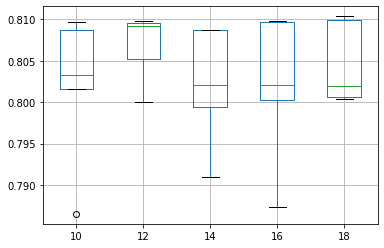

In [34]:
df_precisions = pd.DataFrame(df_precisions)
df_precisions.boxplot()

In [16]:
if not test_locally:
    # Write the entire dataset as trainig
    train_file = create_labelled_file("cross_val/train_fasttext_full.txt", df)

In [43]:
# We must find the correct epochs star using cross validation!
if not test_locally:
    epochs_star = 25
    %time model = fasttext.train_supervised("cross_val/train_fasttext_full.txt", epoch=epochs_star, loss='hs')

In [44]:
if not test_locally:
    # We have to get the test dataset and clean it as we have done with the training dataset
    df_test = []
    with open("Data/test_data.txt", 'r') as f:
        for l in f:
            id_ = l.split(",")[0]
            # it is a csv, but you have to keep other commas (only the first one is relevant)
            sentence = ",".join(l.split(",")[1:])
            df_test.append({
                "label": int(id_),
                "sentence": sentence
            })
    df_test = pd.DataFrame(df_test)
    df_test.head()

In [45]:
if not test_locally:
    for clean_option in cleaning_options:
        df_test = clean[clean_option](df_test)
        print(clean_option)
        print(df_test.head())
        print("################################\n\n")

clean_new_line
                                            sentence  label
0  sea doo pro sea scooter ( sports with the port...      1
1  <user> shucks well i work all week so now i ca...      2
2            i cant stay away from bug thats my baby      3
3  <user> no ma'am ! ! ! lol im perfectly fine an...      4
4  whenever i fall asleep watching the tv , i alw...      5
################################


remove_stopwords
                                            sentence  label
0  sea doo pro sea scooter ( sports portable sea-...      1
1  <user> shucks well work week can't come cheer ...      2
2                      cant stay away bug thats baby      3
3  <user> ma'am ! ! ! lol im perfectly fine conta...      4
4  whenever fall asleep watching tv , always wake...      5
################################


clean_tags
                                            sentence  label
0  sea doo pro sea scooter ( sports portable sea-...      1
1  shucks well work week can't come cheer ! oh 

In [46]:
if not test_locally:
    # The label follows the wildcard __label__
    series_predictions = df_test.sentence.apply(lambda x: model.predict(x)[0][0].split("__label__")[1])
    results = pd.DataFrame({
        "Id": df_test['label'],
        "Prediction": series_predictions
    })

In [47]:
results.head()

,Id,Prediction
0,1,-1
1,2,-1
2,3,-1
3,4,1
4,5,-1


In [48]:
results.to_csv('Submission.csv', index=False)